#  Encoder-Decoder Seq2Seq for Machine Translation

In so-called seq2seq problems like machine translation,
where inputs and outputs both consist 
of variable-length unaligned sequences,
we generally rely on encoder-decoder architectures.
In this section,
we will demonstrate the application 
of an encoder-decoder architecture,
where both the encoder and decoder 
are implemented as RNNs.

Here, the encoder RNN will take a variable-length sequence as input 
and transform it into a fixed-shape hidden state.
Later, 
we will introduce attention mechanisms, 
which allow us to access encoded inputs
without having to compress the entire input
into a single fixed-length representation.

Then to generate the output sequence, 
one token at a time,
the decoder model, 
consisting of a separate RNN,
will predict each successive target token
given both the input sequence
and the preceding tokens in the output.
During training, the decoder will typically
be conditioned upon the preceding tokens
in the official "ground-truth" label. 
However, at test time, we will want to condition
each output of the decoder on the tokens already predicted. 
Note that if we ignore the encoder,
the decoder in a seq2seq architecture 
behaves just like a normal language model.

The special "&lt;eos&gt;" token
marks the end of the sequence.
Our model can stop making predictions
once this token is generated.
At the initial time step of the RNN decoder,
there are two special design decisions to be aware of:
First, we begin every input with a special 
beginning-of-sequence "&lt;bos&gt;" token.
Second, we may feed
the final hidden state of the encoder
into the decoder
at every single decoding time step (`Cho.Van-Merrienboer.Gulcehre.ea.2014`).
In some other designs,
such as `Sutskever.Vinyals.Le.2014`,
the final hidden state of the RNN encoder
is used
to initiate the hidden state of the decoder
only at the first decoding step.



## Teacher Forcing

While running the encoder on the input sequence
is relatively straightforward,
how to handle the input and output 
of the decoder requires more care. 
The most common approach is sometimes called *teacher forcing*.
Here, the original target sequence (token labels)
is fed into the decoder as input.
More concretely,
the special beginning-of-sequence token
and the original target sequence,
excluding the final token,
are concatenated as input to the decoder,
while the decoder output (labels for training) is
the original target sequence,
shifted by one token:
"&lt;bos&gt;", "Ils", "regardent", "." $\rightarrow$
"Ils", "regardent", ".", "&lt;eos&gt;".

Our implementation 
prepared training data for teacher forcing,
where shifting tokens for self-supervised learning
is similar to the training of language models.
An alternative approach is
to feed the *predicted* token
from the previous time step
as the current input to the decoder.


In the following, we explain the design 
in greater detail.
We will train this model for machine translation
on the English-French dataset.


In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

## Encoder

Recall that the encoder transforms an input sequence of variable length
into a fixed-shape *context variable* $\mathbf{c}$.


Consider a single sequence example (batch size 1).
Suppose that the input sequence is $x_1, \ldots, x_T$, 
such that $x_t$ is the $t^{\mathrm{th}}$ token.
At time step $t$, the RNN transforms
the input feature vector $\mathbf{x}_t$ for $x_t$
and the hidden state $\mathbf{h} _{t-1}$ 
from the previous time step 
into the current hidden state $\mathbf{h}_t$.
We can use a function $f$ to express 
the transformation of the RNN's recurrent layer:

$$\mathbf{h}_t = f(\mathbf{x}_t, \mathbf{h}_{t-1}). $$

In general, the encoder transforms 
the hidden states at all time steps
into a context variable through a customized function $q$:

$$\mathbf{c} =  q(\mathbf{h}_1, \ldots, \mathbf{h}_T).$$

For example,
the context variable is just the hidden state $\mathbf{h}_T$
corresponding to the encoder RNN's representation
after processing the final token of the input sequence.

In this example, we have used a unidirectional RNN
to design the encoder,
where the hidden state only depends on the input subsequence 
at and before the time step of the hidden state.
We can also construct encoders using bidirectional RNNs.
In this case, a hidden state depends on the subsequence before and after the time step 
(including the input at the current time step), 
which encodes the information of the entire sequence.


Now let's **implement the RNN encoder**.
Note that we use an *embedding layer*
to obtain the feature vector for each token in the input sequence.
The weight of an embedding layer is a matrix,
where the number of rows corresponds to 
the size of the input vocabulary (`vocab_size`)
and number of columns corresponds to 
the feature vector's dimension (`embed_size`).
For any input token index $i$,
the embedding layer fetches the $i^{\mathrm{th}}$ row 
(starting from 0) of the weight matrix
to return its feature vector.
Here we implement the encoder with a multilayer GRU.


In [16]:
class Seq2SeqEncoder(d2l.Encoder):
    """The RNN encoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # embedding
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # X shape：(batch_size, num_steps, embed_size)
        X = self.embedding(X)
        # in RNN, the first dimension is num_steps
        X = X.permute(1, 0, 2)
        # for unknown state, default as 0
        output, state = self.rnn(X)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return output, state

Let's use a concrete example
to **illustrate the above encoder implementation.**
Below, we instantiate a two-layer GRU encoder
whose number of hidden units is 16.
Given a minibatch of sequence inputs `X`
(batch size: 4, number of time steps: 9),
the hidden states of the last layer
at all the time steps
(`enc_outputs` returned by the encoder's recurrent layers)
are a tensor of shape
(number of time steps, batch size, number of hidden units).


In [17]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape # outputs shape: (num_steps, batch_size, num_hiddens)

torch.Size([7, 4, 16])

Since we are using a GRU here,
the shape of the multilayer hidden states
at the final time step is
(number of hidden layers, batch size, number of hidden units).


In [18]:
state.shape # state shape: (num_layers, batch_size, num_hiddens)

torch.Size([2, 4, 16])

## Decoder

Given a target output sequence $y_1, y_2, \ldots, y_{T'}$
for each time step $t'$
(we use $t^\prime$ to differentiate from the input sequence time steps),
the decoder assigns a predicted probability
to each possible token occurring at step $y_{t'+1}$
conditioned upon the previous tokens in the target
$y_1, \ldots, y_{t'}$ 
and the context variable 
$\mathbf{c}$, i.e., $P(y_{t'+1} \mid y_1, \ldots, y_{t'}, \mathbf{c})$.

To predict the subsequent token $t^\prime+1$ in the target sequence,
the RNN decoder takes the previous step's target token $y_{t^\prime}$,
the hidden RNN state from the previous time step $\mathbf{s}_{t^\prime-1}$,
and the context variable $\mathbf{c}$ as its input,
and transforms them into the hidden state 
$\mathbf{s}_{t^\prime}$ at the current time step.
We can use a function $g$ to express 
the transformation of the decoder's hidden layer:

$$\mathbf{s}_{t^\prime} = g(y_{t^\prime-1}, \mathbf{c}, \mathbf{s}_{t^\prime-1}).$$


After obtaining the hidden state of the decoder,
we can use an output layer and the softmax operation 
to compute the predictive distribution
$p(y_{t^{\prime}+1} \mid y_1, \ldots, y_{t^\prime}, \mathbf{c})$ 
over the subsequent output token ${t^\prime+1}$.

When implementing the decoder as follows,
we directly use the hidden state at the final time step
of the encoder
to initialize the hidden state of the decoder.
This requires that the RNN encoder and the RNN decoder 
have the same number of layers and hidden units.
To further incorporate the encoded input sequence information,
the context variable is concatenated
with the decoder input at all the time steps.
To predict the probability distribution of the output token,
we use a fully connected layer
to transform the hidden state 
at the final layer of the RNN decoder.


In [19]:
class Seq2SeqDecoder(d2l.Decoder):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1] # output, state = encoder(X)

    def forward(self, X, state):
        # X shape：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return output, state

To **illustrate the implemented decoder**,
below we instantiate it with the same hyperparameters from the aforementioned encoder.
As we can see, the output shape of the decoder becomes (batch size, number of time steps, vocabulary size),
where the last dimension of the tensor stores the predicted token distribution.


In [20]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape 
# outputs shape: (batch_size, num_steps, vocab_size) 
# hidden_state shape: (num_layers, batch_size, num_hiddens)

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

## Loss Function with Masking

At each time step, the decoder predicts 
a probability distribution for the output tokens.
As with language modeling, 
we can apply softmax 
to obtain the distribution
and calculate the cross-entropy loss for optimization.
Recall 
that the special padding tokens
are appended to the end of sequences
so sequences of varying lengths
can be efficiently loaded
in minibatches of the same shape.
However, prediction of padding tokens
should be excluded from loss calculations.
To this end, we can 
**mask irrelevant entries with zero values**
so that multiplication 
of any irrelevant prediction
with zero equals to zero.


In [21]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries with zero values"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value # ~: opposite
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [10]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [11]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """Cross entropy loss with mask"""
    # pred shape：(batch_size,num_steps,vocab_size)
    # label shape：(batch_size,num_steps)
    # valid_len shape：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        return weighted_loss

In [22]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

## Training

Now we can **create and train an RNN encoder-decoder model**
for sequence to sequence learning on the machine translation dataset.


In [23]:
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train Seq2Seq model"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # sum of training loss, number of words
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  #teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.019, 9739.2 tokens/sec on cpu


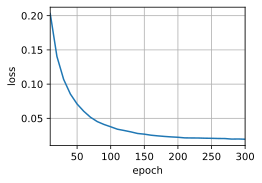

In [24]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## Prediction

To predict the output sequence
at each step, 
the predicted token from the previous
time step is fed into the decoder as an input.
One simple strategy is to sample whichever token
the decoder has assigned the highest probability
when predicting at each step.
As in training, at the initial time step
the beginning-of-sequence ("&lt;bos&gt;") token
is fed into the decoder.
When the end-of-sequence ("&lt;eos&gt;") token is predicted,
the prediction of the output sequence is complete.

In the next section, we will introduce 
more sophisticated strategies 
based on beam search.


In [26]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """Prediction of the Seq2Seq model"""
    # set net as evaluation mode
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # save attention weights
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

## Evaluation of Predicted Sequences

We can evaluate a predicted sequence
by comparing it with the
target sequence (the ground-truth).
But what precisely is the appropriate measure 
for comparing similarity between two sequences?


BLEU (Bilingual Evaluation Understudy),
though originally proposed for evaluating
machine translation results (`Papineni.Roukos.Ward.ea.2002`),
has been extensively used in measuring
the quality of output sequences for different applications.
In principle, for any $n$-grams in the predicted sequence,
BLEU evaluates whether this $n$-grams appears
in the target sequence.

Denote by $p_n$ the precision of $n$-grams,
which is the ratio 
of the number of matched $n$-grams in
the predicted and target sequences
to the number of $n$-grams in the predicted sequence.
To explain, given a target sequence $A$, $B$, $C$, $D$, $E$, $F$,
and a predicted sequence $A$, $B$, $B$, $C$, $D$,
we have $p_1 = 4/5$,  $p_2 = 3/4$, $p_3 = 1/3$, and $p_4 = 0$.
Besides, let $\mathrm{len}_{\text{label}}$ and $\mathrm{len}_{\text{pred}}$
be the numbers of tokens in the target sequence 
and the predicted sequence, respectively.
Then, BLEU is defined as

$$ \exp\left(\min\left(0, 1 - \frac{\mathrm{len}_{\text{label}}}{\mathrm{len}_{\text{pred}}}\right)\right) \prod_{n=1}^k p_n^{1/2^n},$$
:eqlabel:`eq_bleu`

where $k$ is the longest $n$-grams for matching.

Based on the definition of BLEU in :eqref:`eq_bleu`,
whenever the predicted sequence is the same as the target sequence, BLEU is 1.
Moreover,
since matching longer $n$-grams is more difficult,
BLEU assigns a greater weight
to a longer $n$-gram precision.
Specifically, when $p_n$ is fixed,
$p_n^{1/2^n}$ increases as $n$ grows (the original paper uses $p_n^{1/n}$).
Furthermore,
since
predicting shorter sequences
tends to obtain a higher $p_n$ value,
the coefficient before the multiplication term in :eqref:`eq_bleu`
penalizes shorter predicted sequences.
For example, when $k=2$,
given the target sequence $A$, $B$, $C$, $D$, $E$, $F$ and the predicted sequence $A$, $B$,
although $p_1 = p_2 = 1$, the penalty factor $\exp(1-6/2) \approx 0.14$ lowers the BLEU.

We **implement the BLEU measure** as follows.


In [27]:
def bleu(pred_seq, label_seq, k):  
    """Compute the BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In the end,
we use the trained RNN encoder-decoder
to **translate a few English sentences into French**
and compute the BLEU of the results.


In [28]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il a <unk> <unk> ., bleu 0.000
i'm home . => je suis de homme !, bleu 0.447


## Summary

Following the design of the encoder-decoder architecture, we can use two RNNs to design a model for sequence to sequence learning.
In encoder-decoder training, the teacher forcing approach feeds original output sequences (in contrast to predictions) into the decoder.
When implementing the encoder and the decoder, we can use multilayer RNNs.
We can use masks to filter out irrelevant computations, such as when calculating the loss.
As for evaluating output sequences,
BLEU is a popular measure by matching $n$-grams between the predicted sequence and the target sequence.